In [1]:
import numpy as np
import tensorflow as tf
import scipy.io as sio
import os
import matplotlib.pyplot as plt

Load Data
(90270, 697)


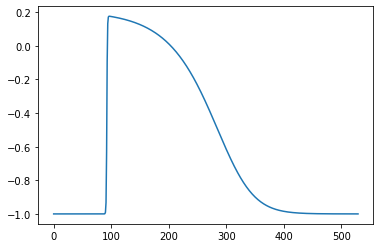

(90270, 64)


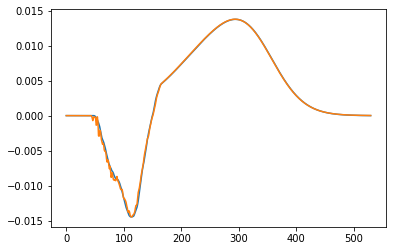

In [2]:
print('Load Data')
# load H matrix
H_matrix_path = 'D:/research/data/ECGSimdata/H1.mat'
Phi_input = sio.loadmat(H_matrix_path)['H'].T
# load TMP
TMP_path = 'D:/research/data/ECGSimdata/TMP.mat'
TMP = sio.loadmat(TMP_path)['TMP'].T
Training_labels = TMP / 85
# print(Training_labels)
print(Training_labels.shape)
plt.plot(Training_labels[0:530, 1])
plt.show()
# TMP = TMP.reshape(257, 505, 1000)
# load bsp
bsp_path = 'D:/research/data/ECGSimdata/BSP.mat'
bsp = sio.loadmat(bsp_path)['BSP'].T
plt.plot(bsp[0:530,1]/85)
# Training_inputs = bsp 

Training_inputs = np.dot(Training_labels, Phi_input)
print(Training_inputs.shape)
plt.plot(Training_inputs[0:530,1])
plt.show()

# bsp = bsp.reshape(64, 505, 1000)
# load L
# L_path = 'D:/research/data/TMP simulation/L.mat'
# L = sio.loadmat(L_path)['L']

In [3]:
# initialize x with tikhonov
# H_TH = np.dot(Hmatrix.T, Hmatrix)
# L_TL = np.dot(L.T, L)
# inverse = np.linalg.inv(H_TH + 0.01 * L_TL)
# PhiInv_input = np.dot(inverse, Hmatrix.T)
# PhiTPhi_input = H_TH
# del H_TH, L_TL, inverse

# initialize
n_input = 64
n_output = 697
batch_size = 256
PhaseNumber = 9
learning_rate = 0.00001
Epoch_num = 1000
nrtrain = 90270


XX = Training_labels.transpose() #(697, 531)
BB = np.dot(Phi_input.transpose(), XX) # (64, 531)
BBB = np.dot(BB, BB.transpose())# (64, 64) 
CCC = np.dot(XX, BB.transpose())# (697, 64)
PhiT_ = np.dot(CCC, np.linalg.inv(BBB))# (697, 64)
del XX, BB, BBB
PhiInv_input = PhiT_.transpose()# (64, 697)
PhiTPhi_input = np.dot(Phi_input, Phi_input.transpose())# (697, 697)

Phi = tf.constant(Phi_input, dtype=tf.float32)
PhiTPhi = tf.constant(PhiTPhi_input, dtype=tf.float32)
PhiInv = tf.constant(PhiInv_input, dtype=tf.float32)

X_input = tf.placeholder(tf.float32, [None, n_input])
X_output = tf.placeholder(tf.float32, [None, n_output])


X0 = tf.matmul(X_input, PhiInv)# (531, 697)

PhiTb = tf.matmul(X_input, tf.transpose(Phi))# (531, 697)

In [4]:
# initialize parameters
def add_con2d_weight_bias(w_shape, b_shape, order_no):
    Weights = tf.get_variable(shape=w_shape, initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='Weights_%d' % order_no)
    biases = tf.Variable(tf.random_normal(b_shape, stddev=0.05), name='biases_%d' % order_no)
    return [Weights, biases]

In [5]:
# initialize parameters
def ista_block(input_layers, input_data, layer_no):
    tau_value = tf.Variable(0.1, dtype=tf.float32)
    lambda_step = tf.Variable(0.1, dtype=tf.float32)
    soft_thr = tf.Variable(0.1, dtype=tf.float32)
    conv_size = 32
    filter_size = 3
    x1_ista = tf.add(input_layers[-1] - tf.scalar_mul(lambda_step, tf.matmul(input_layers[-1], PhiTPhi)), tf.scalar_mul(lambda_step, PhiTb))  # X_k - lambda*A^TAX

    x2_ista = tf.reshape(x1_ista, shape=[-1, 17, 41, 1])

    [Weights0, bias0] = add_con2d_weight_bias([filter_size, filter_size, 1, conv_size], [conv_size], 0)

    [Weights1, bias1] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 1)
    [Weights11, bias11] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 11)

    [Weights2, bias2] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 2)
    [Weights22, bias22] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 22)

    [Weights3, bias3] = add_con2d_weight_bias([filter_size, filter_size, conv_size, 1], [1], 3)

    x3_ista = tf.nn.conv2d(x2_ista, Weights0, strides=[1, 1, 1, 1], padding='SAME')

    x4_ista = tf.nn.relu(tf.nn.conv2d(x3_ista, Weights1, strides=[1, 1, 1, 1], padding='SAME'))
    x44_ista = tf.nn.conv2d(x4_ista, Weights11, strides=[1, 1, 1, 1], padding='SAME')

    x5_ista = tf.multiply(tf.sign(x44_ista), tf.nn.relu(tf.abs(x44_ista) - soft_thr))

    x6_ista = tf.nn.relu(tf.nn.conv2d(x5_ista, Weights2, strides=[1, 1, 1, 1], padding='SAME'))
    x66_ista = tf.nn.conv2d(x6_ista, Weights22, strides=[1, 1, 1, 1], padding='SAME')

    x7_ista = tf.nn.conv2d(x66_ista, Weights3, strides=[1, 1, 1, 1], padding='SAME')

    x7_ista = x7_ista + x2_ista

    x8_ista = tf.reshape(x7_ista, shape=[-1, 697])

    x3_ista_sym = tf.nn.relu(tf.nn.conv2d(x3_ista, Weights1, strides=[1, 1, 1, 1], padding='SAME'))
    x4_ista_sym = tf.nn.conv2d(x3_ista_sym, Weights11, strides=[1, 1, 1, 1], padding='SAME')
    x6_ista_sym = tf.nn.relu(tf.nn.conv2d(x4_ista_sym, Weights2, strides=[1, 1, 1, 1], padding='SAME'))
    x7_ista_sym = tf.nn.conv2d(x6_ista_sym, Weights22, strides=[1, 1, 1, 1], padding='SAME')

    x11_ista = x7_ista_sym - x3_ista

    return [x8_ista, x11_ista]

In [6]:
def inference_ista(input_tensor, n, X_output, reuse):
    layers = []
    layers_symetric = []
    layers.append(input_tensor)
    for i in range(n):
        with tf.variable_scope('conv_%d' %i, reuse=reuse):
            [conv1, conv1_sym] = ista_block(layers, X_output, i)
            layers.append(conv1)
            layers_symetric.append(conv1_sym)
    return [layers, layers_symetric]

In [7]:
[Prediction, Pre_symetric] = inference_ista(X0, PhaseNumber, X_output, reuse=False)

cost0 = tf.reduce_mean(tf.square(X0 - X_output))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
def compute_cost(Prediction, X_output, PhaseNumber):
    cost = tf.reduce_mean(tf.square(Prediction[-1] - X_output))
    cost_sym = 0
    for k in range(PhaseNumber):
        cost_sym += tf.reduce_mean(tf.square(Pre_symetric[k]))

    return [cost, cost_sym]

In [9]:
[cost, cost_sym] = compute_cost(Prediction, X_output, PhaseNumber)
cost_all = cost + 0.01*cost_sym

In [10]:
optm_all = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_all)

init = tf.global_variables_initializer()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

saver = tf.train.Saver(tf.global_variables(), max_to_keep=100)

In [11]:
sess = tf.Session(config=config)
sess.run(init)

print("...............................")
print("Phase Number is %d" % PhaseNumber)
print("...............................\n")

print("Strart Training..")


model_dir = 'Phase_%d_ISTA_Net_plus_Model' % PhaseNumber

output_file_name = "Log_output_%s.txt" % (model_dir)

for epoch_i in range(0, Epoch_num+1):
    randidx_all = np.random.permutation(nrtrain)
    for batch_i in range(nrtrain // batch_size):
        randidx = randidx_all[batch_i*batch_size:(batch_i+1)*batch_size]

        batch_ys = Training_labels[randidx, :]
        batch_xs = np.dot(batch_ys, Phi_input)

        feed_dict = {X_input: batch_xs, X_output: batch_ys}
        sess.run(optm_all, feed_dict=feed_dict)

    output_data = "[%02d/%02d] cost: %.4f, cost_sym: %.4f \n" % (epoch_i, Epoch_num, sess.run(cost, feed_dict=feed_dict), sess.run(cost_sym, feed_dict=feed_dict))
    print(output_data)

    output_file = open(output_file_name, 'a')
    output_file.write(output_data)
    output_file.close()

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    if epoch_i <= 30:
        saver.save(sess, './%s/CS_Saved_Model_%d.cpkt' % (model_dir, epoch_i), write_meta_graph=False)
    else:
        if epoch_i % 20 == 0:
            saver.save(sess, './%s/CS_Saved_Model_%d.cpkt' % (model_dir, epoch_i), write_meta_graph=False)


print("Training Finished")
sess.close()

...............................
Phase Number is 9
...............................

Strart Training..
[00/1000] cost: 0.1269, cost_sym: 0.5555 

[01/1000] cost: 0.1049, cost_sym: 0.5883 

[02/1000] cost: 0.0825, cost_sym: 0.5131 

[03/1000] cost: 0.0592, cost_sym: 0.3979 

[04/1000] cost: 0.0619, cost_sym: 0.3571 

[05/1000] cost: 0.0700, cost_sym: 0.3304 

[06/1000] cost: 0.0639, cost_sym: 0.3065 

[07/1000] cost: 0.0688, cost_sym: 0.3012 

[08/1000] cost: 0.0622, cost_sym: 0.3006 

[09/1000] cost: 0.0615, cost_sym: 0.2842 

[10/1000] cost: 0.0573, cost_sym: 0.2740 

[11/1000] cost: 0.0575, cost_sym: 0.2479 

[12/1000] cost: 0.0494, cost_sym: 0.2186 

[13/1000] cost: 0.0538, cost_sym: 0.2074 

[14/1000] cost: 0.0526, cost_sym: 0.2279 

[15/1000] cost: 0.0462, cost_sym: 0.2043 

[16/1000] cost: 0.0505, cost_sym: 0.2121 

[17/1000] cost: 0.0435, cost_sym: 0.1933 

[18/1000] cost: 0.0469, cost_sym: 0.1896 

[19/1000] cost: 0.0500, cost_sym: 0.1980 

[20/1000] cost: 0.0478, cost_sym: 0.183

[187/1000] cost: 0.0234, cost_sym: 0.0986 

[188/1000] cost: 0.0220, cost_sym: 0.0793 

[189/1000] cost: 0.0269, cost_sym: 0.0888 

[190/1000] cost: 0.0222, cost_sym: 0.0832 

[191/1000] cost: 0.0219, cost_sym: 0.0843 

[192/1000] cost: 0.0243, cost_sym: 0.0848 

[193/1000] cost: 0.0250, cost_sym: 0.0805 

[194/1000] cost: 0.0218, cost_sym: 0.0699 

[195/1000] cost: 0.0236, cost_sym: 0.0800 

[196/1000] cost: 0.0256, cost_sym: 0.0880 

[197/1000] cost: 0.0216, cost_sym: 0.0753 

[198/1000] cost: 0.0219, cost_sym: 0.0793 

[199/1000] cost: 0.0224, cost_sym: 0.0716 

[200/1000] cost: 0.0202, cost_sym: 0.0865 

[201/1000] cost: 0.0220, cost_sym: 0.0902 

[202/1000] cost: 0.0249, cost_sym: 0.0779 

[203/1000] cost: 0.0270, cost_sym: 0.0801 

[204/1000] cost: 0.0219, cost_sym: 0.0760 

[205/1000] cost: 0.0225, cost_sym: 0.0753 

[206/1000] cost: 0.0234, cost_sym: 0.0871 

[207/1000] cost: 0.0247, cost_sym: 0.0901 

[208/1000] cost: 0.0209, cost_sym: 0.0694 

[209/1000] cost: 0.0229, cost_sy

[374/1000] cost: 0.0188, cost_sym: 0.0775 

[375/1000] cost: 0.0195, cost_sym: 0.0681 

[376/1000] cost: 0.0200, cost_sym: 0.0702 

[377/1000] cost: 0.0167, cost_sym: 0.0690 

[378/1000] cost: 0.0181, cost_sym: 0.0640 

[379/1000] cost: 0.0195, cost_sym: 0.0673 

[380/1000] cost: 0.0165, cost_sym: 0.0643 

[381/1000] cost: 0.0174, cost_sym: 0.0594 

[382/1000] cost: 0.0155, cost_sym: 0.0619 

[383/1000] cost: 0.0157, cost_sym: 0.0602 

[384/1000] cost: 0.0200, cost_sym: 0.0623 

[385/1000] cost: 0.0198, cost_sym: 0.0688 

[386/1000] cost: 0.0183, cost_sym: 0.0652 

[387/1000] cost: 0.0168, cost_sym: 0.0750 

[388/1000] cost: 0.0157, cost_sym: 0.0731 

[389/1000] cost: 0.0162, cost_sym: 0.0533 

[390/1000] cost: 0.0213, cost_sym: 0.0717 

[391/1000] cost: 0.0186, cost_sym: 0.0574 

[392/1000] cost: 0.0173, cost_sym: 0.0686 

[393/1000] cost: 0.0160, cost_sym: 0.0648 

[394/1000] cost: 0.0204, cost_sym: 0.0701 

[395/1000] cost: 0.0168, cost_sym: 0.0698 

[396/1000] cost: 0.0209, cost_sy

[561/1000] cost: 0.0177, cost_sym: 0.0527 

[562/1000] cost: 0.0154, cost_sym: 0.0583 

[563/1000] cost: 0.0160, cost_sym: 0.0488 

[564/1000] cost: 0.0126, cost_sym: 0.0527 

[565/1000] cost: 0.0140, cost_sym: 0.0487 

[566/1000] cost: 0.0179, cost_sym: 0.0563 

[567/1000] cost: 0.0146, cost_sym: 0.0536 

[568/1000] cost: 0.0142, cost_sym: 0.0533 

[569/1000] cost: 0.0146, cost_sym: 0.0478 

[570/1000] cost: 0.0144, cost_sym: 0.0615 

[571/1000] cost: 0.0181, cost_sym: 0.0481 

[572/1000] cost: 0.0157, cost_sym: 0.0602 

[573/1000] cost: 0.0143, cost_sym: 0.0487 

[574/1000] cost: 0.0172, cost_sym: 0.0613 

[575/1000] cost: 0.0161, cost_sym: 0.0438 

[576/1000] cost: 0.0184, cost_sym: 0.0659 

[577/1000] cost: 0.0157, cost_sym: 0.0634 

[578/1000] cost: 0.0150, cost_sym: 0.0590 

[579/1000] cost: 0.0124, cost_sym: 0.0458 

[580/1000] cost: 0.0155, cost_sym: 0.0631 

[581/1000] cost: 0.0153, cost_sym: 0.0432 

[582/1000] cost: 0.0145, cost_sym: 0.0598 

[583/1000] cost: 0.0184, cost_sy

[748/1000] cost: 0.0152, cost_sym: 0.0536 

[749/1000] cost: 0.0125, cost_sym: 0.0549 

[750/1000] cost: 0.0112, cost_sym: 0.0468 

[751/1000] cost: 0.0153, cost_sym: 0.0486 

[752/1000] cost: 0.0122, cost_sym: 0.0380 

[753/1000] cost: 0.0154, cost_sym: 0.0418 

[754/1000] cost: 0.0134, cost_sym: 0.0533 

[755/1000] cost: 0.0146, cost_sym: 0.0447 

[756/1000] cost: 0.0116, cost_sym: 0.0478 

[757/1000] cost: 0.0148, cost_sym: 0.0520 

[758/1000] cost: 0.0148, cost_sym: 0.0486 

[759/1000] cost: 0.0142, cost_sym: 0.0499 

[760/1000] cost: 0.0156, cost_sym: 0.0459 

[761/1000] cost: 0.0147, cost_sym: 0.0492 

[762/1000] cost: 0.0140, cost_sym: 0.0423 

[763/1000] cost: 0.0146, cost_sym: 0.0502 

[764/1000] cost: 0.0162, cost_sym: 0.0458 

[765/1000] cost: 0.0138, cost_sym: 0.0489 

[766/1000] cost: 0.0158, cost_sym: 0.0457 

[767/1000] cost: 0.0139, cost_sym: 0.0527 

[768/1000] cost: 0.0155, cost_sym: 0.0560 

[769/1000] cost: 0.0125, cost_sym: 0.0438 

[770/1000] cost: 0.0141, cost_sy

[935/1000] cost: 0.0114, cost_sym: 0.0430 

[936/1000] cost: 0.0099, cost_sym: 0.0375 

[937/1000] cost: 0.0132, cost_sym: 0.0405 

[938/1000] cost: 0.0115, cost_sym: 0.0417 

[939/1000] cost: 0.0112, cost_sym: 0.0314 

[940/1000] cost: 0.0119, cost_sym: 0.0444 

[941/1000] cost: 0.0111, cost_sym: 0.0407 

[942/1000] cost: 0.0151, cost_sym: 0.0468 

[943/1000] cost: 0.0135, cost_sym: 0.0420 

[944/1000] cost: 0.0147, cost_sym: 0.0420 

[945/1000] cost: 0.0115, cost_sym: 0.0422 

[946/1000] cost: 0.0114, cost_sym: 0.0406 

[947/1000] cost: 0.0138, cost_sym: 0.0372 

[948/1000] cost: 0.0125, cost_sym: 0.0379 

[949/1000] cost: 0.0158, cost_sym: 0.0412 

[950/1000] cost: 0.0124, cost_sym: 0.0432 

[951/1000] cost: 0.0119, cost_sym: 0.0385 

[952/1000] cost: 0.0141, cost_sym: 0.0387 

[953/1000] cost: 0.0101, cost_sym: 0.0339 

[954/1000] cost: 0.0115, cost_sym: 0.0327 

[955/1000] cost: 0.0132, cost_sym: 0.0379 

[956/1000] cost: 0.0138, cost_sym: 0.0429 

[957/1000] cost: 0.0115, cost_sy